# Energy Disaggregation
#### Final Project on Machine Learning Course, March 2023
#### Team 37
Authors: B. Kazbekov, A. Zhanatbekov, A. Burov, S. Moghimian, I. Kamyshev

## Imports

In [1]:
from __future__ import annotations

from tqdm import tqdm
from functools import reduce
from sklearn.manifold import TSNE
from timm.utils import AverageMeter
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.decomposition import FastICA
from fryze_utils import generate_input_feature
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score

import os
import sys
import math
import random
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.set_default_dtype(torch.float64)

warnings.filterwarnings('ignore')

## Datasets

Signatures of real appliances from PLAID dataset

In [2]:
X_real = np.load('data/X_real.npy', allow_pickle=True)
y_real = np.load('data/y_real.npy', allow_pickle=True)
X_real.shape, y_real.shape

((19400, 400), (19400,))

In [3]:
# Drop classes which are less than 10 samples (due to further train/test split)
_, counts = np.unique(y_real, return_counts=True)
to_drop = np.argwhere(counts < 10).ravel()
for idx in to_drop:
    mask = y_real != idx
    y_real = y_real[mask]
    X_real = X_real[mask]
X_real.shape, y_real.shape

((19398, 400), (19398,))

In [4]:
n_classes = len(np.unique(y_real))
n_classes

15

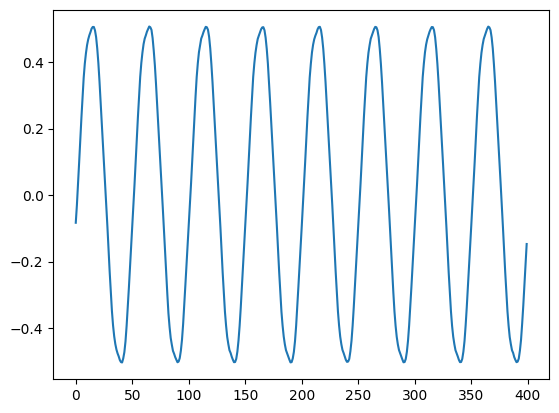

In [5]:
idx = random.randint(0, len(X_real) - 1)
plt.plot(X_real[idx])
plt.show()

In [6]:
lenc = np.load('data/real_label_encoder.npy', allow_pickle=True).item()

Signatures of synthetic appliances

In [7]:
X_synth = np.load('data/X_synth.npy', allow_pickle=True)
y_synth = np.load('data/y_synth.npy', allow_pickle=True)
X_synth.shape, y_synth.shape

((19398, 400), (19398,))

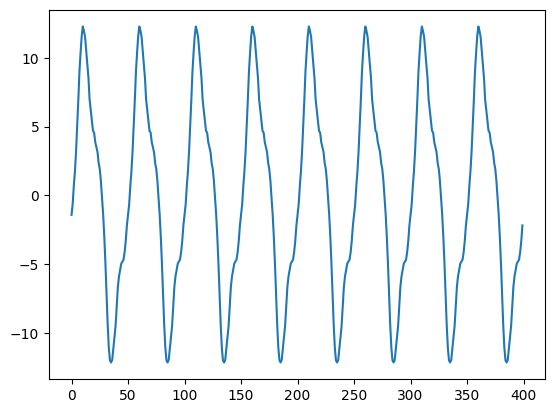

In [8]:
idx = random.randint(0, len(X_synth) - 1)
plt.plot(X_synth[idx])
plt.show()

Split both datasets into train/val/test with the ratio 0.7/0.1/0.2 respectively

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_real,
    y_real,
    test_size=0.3,
    random_state=42,
    stratify=y_real,
)
X_real_val, X_real_test, y_real_val, y_real_test = train_test_split(
    X_real_test,
    y_real_test,
    test_size=0.7,
    random_state=42,
    stratify=y_real_test,
)

In [10]:
X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(
    X_synth,
    y_synth,
    test_size=0.3,
    random_state=42,
    stratify=y_synth,
)
X_synth_val, X_synth_test, y_synth_val, y_synth_test = train_test_split(
    X_synth_test,
    y_synth_test,
    test_size=0.7,
    random_state=42,
    stratify=y_synth_test,
)

In [11]:
print('Real appliances:\n'\
      '\ttrain size = %d / val size = %d / test size = %d\n' %
      (len(y_real_train), len(y_real_val), len(y_real_test)))
print('Synthetic appliances:\n'\
      '\ttrain size = %d / val size = %d / test size = %d' %
    (len(y_synth_train), len(y_synth_val), len(y_synth_test)))

Real appliances:
	train size = 13578 / val size = 1746 / test size = 4074

Synthetic appliances:
	train size = 13578 / val size = 1746 / test size = 4074


Linear Separability Test 

In [12]:
lr = LogisticRegression()

lr.fit(X_real_train, y_real_train)
y_pred = lr.predict(X_real_test)
print('Real appliances separation accuracy = %.4f' %
      accuracy_score(y_real_test, y_pred))

lr.fit(X_synth_train, y_synth_train)
y_pred = lr.predict(X_synth_test)
print('Synthetic appliances separation accuracy = %.4f' %
      accuracy_score(y_synth_test, y_pred))

Real appliances separation accuracy = 0.7138
Synthetic appliances separation accuracy = 1.0000


Generate aggregated signals (mixtured signals)

In [13]:
n_min = 1  # Minimum number of components (classes) per mixture signal
n_max = n_classes  # Maximum number of components (classes) per mixture signal
min_freqs = 1  # Minimum number of class members per mixture signal
max_freqs = 10  # Maximum number of class members per mixture signal
n_samples_per_component = 2000  # How many mixture signals with N components

Define random mixture method 

In [14]:
class Composer:

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        random_state=None,
    ) -> None:
        self._X = X
        self._y = y
        self._classes = np.unique(y)
        self._domains = {}
        for l in self._classes:
            domain = np.argwhere(y == l).ravel().tolist()
            self._domains[l] = domain
        self._rng_state = random_state
        if random_state is not None:
            seed_shift = round(np.sum(np.std(X, axis=1)))
            modified_seed = random_state + seed_shift
        else:
            modified_seed = random_state
        self._rng = np.random.RandomState(modified_seed)

    @property
    def classes(self):
        return self._classes

    @property
    def n_classes(self) -> int:
        return len(self.classes)

    @property
    def domains(self):
        return self._domains

    def make_index_set(
        self,
        n_samples: int = 100,
        n_classes: int = 2,
        min_freqs: np.ndarray = None,
        max_freqs: np.ndarray = None,
    ):
        n_combs_max = math.comb(self.n_classes, n_classes)
        n_combs = min(n_samples, n_combs_max)
        Y = set()
        while len(Y) < n_combs:
            comb = self._rng.choice(self.classes, n_classes, replace=False)
            comb = tuple(sorted(comb))
            if comb not in Y:
                Y.add(comb)
        Y = list(map(list, Y))

        if min_freqs is None:
            min_freqs = np.ones(n_classes)
        if max_freqs is None:
            max_freqs = np.ones(n_classes)

        F = self._rng.randint(min_freqs,
                              max_freqs + 1,
                              size=(n_samples, n_classes))

        n_reps = n_samples // len(Y)
        n_rem = n_samples % len(Y)
        rep_distr = np.asarray([n_reps] * len(Y))
        to_rep = self._rng.choice(range(len(rep_distr)),
                                  size=n_rem,
                                  replace=False)
        rep_distr[to_rep] += 1

        I = set()
        for i, n_rep in enumerate(rep_distr):
            y = Y[i]
            f = F[i]
            D = [self.domains[l] for l in y]

            n_max = reduce(
                lambda x, y: x * y,
                [math.comb(len(D[i]) + f[i] - 1, f[i]) for i in range(len(D))])

            Ii = set()
            while len(Ii) < min(n_rep, min(n_max, sys.maxsize)):
                sample = []
                for domain, freq in zip(D, f):
                    sample += self._rng.choice(domain, size=freq, replace=True).\
                                tolist()
                sample = tuple(sorted(sample))
                if sample not in Ii:
                    Ii.add(sample)
            I = I.union(Ii)

        dn = n_samples - len(I)
        if dn > 0:
            warnings.warn('%d samples were not obtained due to '
                          'combinatorial limit.' % dn)

        I = list(map(list, I))

        return I

    def compose_single(self, Ii):
        Ii = np.asarray(Ii)
        x = self._X[Ii]
        y = self.get_labels(Ii)
        x = np.sum(x, axis=0)
        y = np.unique(y)
        return x, y

    def get_labels(self, Ii):
        y = self._y[np.asarray(Ii)]
        return y

    def make_samples(
        self,
        n_samples: int = 100,
        n_classes: int = 2,
        min_freqs: np.ndarray = None,
        max_freqs: np.ndarray = None,
    ):
        I = self.make_index_set(n_samples=n_samples,
                                n_classes=n_classes,
                                min_freqs=min_freqs,
                                max_freqs=max_freqs)
        X = []
        Y = []
        for Ii in I:
            x, y = self.compose_single(Ii)
            X.append(x)
            Y.append(y)

        return X, Y

In [15]:
def compose(X, y, share=1.0):
    c = Composer(X, y, random_state=42)
    X = np.empty((0, X.shape[1]))
    Y = np.empty((0, n_classes))
    lenc = MultiLabelBinarizer(classes=np.unique(y))
    n_samples_train = round(share * n_samples_per_component)
    for n_components in range(n_min, n_max + 1):
        X_i, Y_i = c.make_samples(n_samples_train,
                                  n_components,
                                  min_freqs=min_freqs,
                                  max_freqs=max_freqs)
        X_i = np.stack(X_i)
        Y_i = np.stack(Y_i)
        Y_i = lenc.fit_transform(Y_i)
        X = np.concatenate((X, X_i))
        Y = np.concatenate((Y, Y_i))
    return X, Y

Generate aggregated signals for real appliances

In [16]:
X_real_train, Y_real_train = compose(X_real_train,
                                     y_real_train,
                                     share=len(X_real_train) / len(X_real))
X_real_val, Y_real_val = compose(X_real_val,
                                 y_real_val,
                                 share=len(X_real_val) / len(X_real))
X_real_test, Y_real_test = compose(X_real_test,
                                   y_real_test,
                                   share=len(X_real_test) / len(X_real))

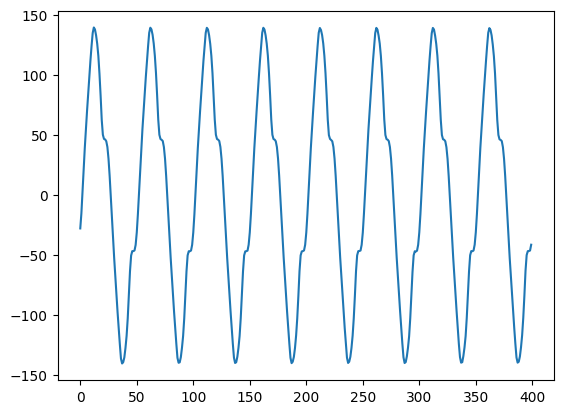

In [17]:
idx = random.randint(0, len(X_real_train) - 1)
plt.plot(X_real_train[idx])
plt.show()

Generate aggregated signals for synthetic appliances

In [18]:
X_synth_train, Y_synth_train = compose(X_synth_train,
                                       y_synth_train,
                                       share=len(X_synth_train) / len(X_synth))
X_synth_val, Y_synth_val = compose(X_synth_val,
                                   y_synth_val,
                                   share=len(X_synth_val) / len(X_synth))
X_synth_test, Y_synth_test = compose(X_synth_test,
                                     y_synth_test,
                                     share=len(X_synth_test) / len(X_synth))

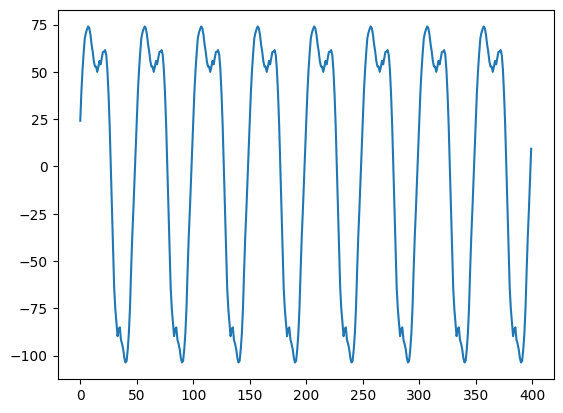

In [19]:
idx = random.randint(0, len(X_synth_train) - 1)
plt.plot(X_synth_train[idx])
plt.show()

Normalize datasets to have unit amplitudes. We normalize in such a way to keep the pattern but loose the information about the absolute magnitude. All nested components will be scaled accordingly. We do not need an absolute magnitude as this task is classification, not the regression i.e. we do not recover power consumption of each component. 

In [20]:
# Make unit magnitude
X_real_train = X_real_train / np.abs(X_real_train).max(axis=1, keepdims=True)
X_real_val = X_real_val / np.abs(X_real_val).max(axis=1, keepdims=True)
X_real_test = X_real_test / np.abs(X_real_test).max(axis=1, keepdims=True)

In [21]:
X_synth_train = X_synth_train / np.abs(X_synth_train).max(axis=1,
                                                          keepdims=True)
X_synth_val = X_synth_val / np.abs(X_synth_val).max(axis=1, keepdims=True)
X_synth_test = X_synth_test / np.abs(X_synth_test).max(axis=1, keepdims=True)

In [22]:
def get_stats(X):
    # Extracts mean and std over each components to be further used 
    # during the training of ICA+ResNetFFN model (ours)
    X = np.exp(X)
    m = X.mean(axis=0, keepdims=True)
    s = X.std(axis=0, keepdims=True, ddof=1)
    return m, s

Define un-mixing matrices for two setups

In [23]:
fica = FastICA(n_classes + 1, whiten=True)
fica.fit(X_real_train)

m_real, s_real = get_stats(fica.transform(X_real_train))
U_real = fica.components_.astype(np.float64)
M_real = fica.mean_.astype(np.float64)


In [24]:
fica.fit(X_synth_train)

m_synth, s_synth = get_stats(fica.transform(X_synth_train))
U_synth = fica.components_.astype(np.float64)
M_synth = fica.mean_.astype(np.float64)

## Torch Dataset Wrapper 

In [25]:
class Data(Dataset):

    def __init__(self, X, Y) -> None:
        super().__init__()
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

## Training Loops

In [26]:
@torch.no_grad()
def f1_with_logits(y_pred, y_test, threshold=0.5, average='samples'):
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.where(y_pred >= threshold, 1, 0)
    y_pred, y_test = y_pred.cpu(), y_test.cpu()
    y_pred, y_test = y_pred.numpy(), y_test.numpy()
    return f1_score(y_test, y_pred, average=average)


score_with_logits = f1_with_logits


def train_epoch(
    model,
    loader,
    loss_fn,
    optimizer,
    device: str = 'cpu',
    threshold=0.5,
    dtype=torch.float64,
) -> dict:

    model.train()
    loss_m = AverageMeter()
    score_m = AverageMeter()

    for _, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device,
                                    dtype=dtype), targets.to(device,
                                                             dtype=dtype)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        score = score_with_logits(outputs, targets, threshold=threshold)

        score_m.update(score, len(inputs))
        loss_m.update(loss.item(), len(inputs))

    return {'train/loss': loss_m.avg, 'train/score': score_m.avg}


@torch.no_grad()
def val_epoch(
    model,
    loader,
    loss_fn,
    device: str = 'cpu',
    dtype=torch.float64,
    threshold=0.5,
) -> dict:
    model.eval()
    loss_m = AverageMeter()
    score_m = AverageMeter()

    true = []
    pred = []

    for _, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device,
                                    dtype=dtype), targets.to(device,
                                                             dtype=dtype)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_m.update(loss.item(), len(inputs))

        pred.append(outputs.cpu())
        true.append(targets.cpu())

    pred = torch.cat(pred, dim=0)
    true = torch.cat(true, dim=0)

    scores = []
    thresholds = torch.linspace(0.1, 1.0, 20)
    for thresh in thresholds:
        scores.append(score_with_logits(pred, true, threshold=thresh.item()))

    opt = np.argmax(scores)
    threshold = thresholds[opt].item()
    score_m.update(scores[opt], len(true))

    return {
        'val/loss': loss_m.avg,
        'val/score': score_m.avg,
        'threshold': threshold,
    }


def train_model(
    model,
    dataloaders,
    loss_fn,
    optimizer,
    num_epochs,
    scheduler=None,
    device='cpu',
    save_checkpoint_dir='',
):
    history = {
        "train": {
            "loss": [],
            "score": []
        },
        "val": {
            "loss": [],
            "score": []
        },
        "threshold": [],
        "lr": [],
    }

    if save_checkpoint_dir:
        os.makedirs(save_checkpoint_dir, exist_ok=True)

    best_val_metric = 0.0

    val_stats = {}
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        train_stats = train_epoch(model,
                                  dataloaders["train"],
                                  loss_fn,
                                  optimizer,
                                  device=device,
                                  threshold=val_stats.get('threshold', 0.5))

        print(
            f"{'Train':>5} Loss: {train_stats['train/loss']:.4f} f1: {train_stats['train/score']:.4f}"
        )

        history["train"]["loss"].append(train_stats['train/loss'])
        history["train"]["score"].append(train_stats['train/score'])

        if dataloaders.get("val"):
            val_stats = val_epoch(model,
                                  dataloaders["val"],
                                  loss_fn,
                                  device=device)

            print(
                f"{'Val':>5} Loss: {val_stats['val/loss']:.4f} f1: {val_stats['val/score']:.4f}"
            )
            history["val"]["loss"].append(val_stats['val/loss'])
            history["val"]["score"].append(val_stats['val/score'])
            if val_stats["val/score"] > best_val_metric:
                best_val_metric = val_stats["val/score"]
                # save best model
                if save_checkpoint_dir:
                    torch.save(
                        {
                            "epoch": epoch,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict()
                        }, f"{save_checkpoint_dir}/best.pt")

        if scheduler:
            scheduler.step(val_stats['val/loss'])

        history['threshold'].append(val_stats.get('threshold', 0.5))
        history['lr'].append(optimizer.param_groups[0]['lr'])

    # save last model
    if save_checkpoint_dir:
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }, f"{save_checkpoint_dir}/last.pt")

    return history


def fryze_data(x):
    x = x.reshape(-1, 8, 50)
    x = x.mean(axis=1)
    t = np.linspace(0, 1 / 60, 50)
    v = 120 * np.sqrt(2) * np.sin(2 * np.pi * 60 * t)
    v = np.repeat(v[None], len(x), axis=0)
    x = generate_input_feature(x, v)
    x = x.to(dtype=torch.float64)
    return x


def run_all(
    model,
    X_train,
    X_val,
    Y_train,
    Y_val,
    lr=1e-2,
    parallel=False,
    device='cuda',
    epochs=250,
    batch_size=128,
    fryze=False,
    num_workers=0,
    prefix='real',
):

    if fryze:
        X_train = fryze_data(X_train)
        X_val = fryze_data(X_val)
    train = Data(X_train, Y_train)
    val = Data(X_val, Y_val)

    train = DataLoader(train, batch_size=batch_size, num_workers=num_workers)
    val = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

    torch.cuda.empty_cache()

    if device == 'cuda':
        model.cuda()
    if parallel:
        model = nn.DataParallel(model, device_ids=[0, 1])

    opt = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(opt,
                                  'min',
                                  factor=0.9,
                                  patience=15,
                                  min_lr=1e-8)
    hist = train_model(
        model=model,
        dataloaders={
            'train': train,
            'val': val
        },
        loss_fn=nn.BCEWithLogitsLoss(),
        optimizer=opt,
        scheduler=scheduler,
        num_epochs=epochs,
        device=device,
        save_checkpoint_dir='./checkpoints/%s/%s' %
        (prefix, model.__class__.__name__),
    )

    if parallel:
        model = model.module

    return model, hist

## Models

ICA+ResNetFFN (ours)

In [27]:
class ICALayer(nn.Module):

    def __init__(self, U, M) -> None:
        super().__init__()
        self.U = torch.tensor(U, dtype=torch.float64, requires_grad=False)
        self.M = torch.tensor(M, dtype=torch.float64, requires_grad=False)

    def forward(self, x):
        device = str(x.device).split(':')[0]
        if self.U.device != device or self.U.device != device:
            self.U = self.U.to(device=device)
            self.M = self.M.to(device=device)
        x = (x - self.M) @ self.U.T
        return x


class Normalize(nn.Module):

    def __init__(self, m=0, s=1) -> None:
        super().__init__()
        self.m = torch.tensor(m, dtype=torch.float64, requires_grad=False)
        self.s = torch.tensor(s, dtype=torch.float64, requires_grad=False)

    def forward(self, x):
        device = str(x.device).split(':')[0]
        if self.m.device != device or self.m.device != device:
            self.m = self.m.to(device=device)
            self.s = self.s.to(device=device)
        x = torch.exp(x)
        x = (x - self.m) / self.s
        return x


class ResFFN(nn.Module):

    def __init__(self, q, p=0.1) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.LazyLinear(q),
            nn.Dropout(p),
            nn.ReLU(),
            nn.LazyLinear(q),
            nn.Dropout(p),
            nn.ReLU(),
        )
        self.norm = nn.LayerNorm(q)

    def forward(self, x):
        r = x.clone()
        x = self.layers(x)
        x = self.norm(r + x)
        return x


class FeedForward(nn.Module):

    def __init__(self, num_features, expansion_factor, dropout):
        super().__init__()
        num_hidden = expansion_factor * num_features
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_features)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout1(F.gelu(self.fc1(x)))
        out = self.dropout2(self.fc2(x))
        return out


def fourier_transform(x):
    return torch.real(torch.fft.fft2(x, dim=-1))
    # return torch.abs(torch.fft.fft2(x, dim=(-1))


class FNetEncoderLayer(nn.Module):

    def __init__(self, d_model, expansion_factor, dropout):
        super().__init__()
        self.ff = FeedForward(d_model, expansion_factor, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = fourier_transform(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.ff(x)
        out = self.norm2(x + residual)
        return out


class FFTLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        x = torch.abs(torch.fft.fft2(x, axis=-1, norm='ortho'))
        return x


class ICAResNetFFN(nn.Module):

    def __init__(self, q, M, U, m, s, p=0.1) -> None:
        super().__init__()
        self.preprocessing = nn.Sequential(
            ICALayer(U, M),
            Normalize(m, s),
        )
        self.ffn = nn.Sequential(
            nn.LazyLinear(q),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
            ResFFN(q, p=p),
        )
        self.clf = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.preprocessing(x)
        x = self.ffn(x)
        x = self.clf(x)
        return x

CNN on Fryze Features from paper "Multi-Label Learning for Appliance Recognition in NILM Using Fryze-Current Decomposition and Convolutional Neural Network"

In [28]:
class FryzeCNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.LazyConv2d(16, 5, 2),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, 2),
            nn.ReLU(),
            nn.LazyConv2d(64, 3, 2),
            nn.ReLU(),
            nn.LazyConv2d(128, 3, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.LazyLinear(n_classes),
        )

    def forward(self, x):
        return self.layers(x)

Temporal Pooling NILM (TP-NILM) from paper "Non-Intrusive Load Disaggregation by Convolutional Neural Network and Multilabel Classification" 

In [29]:
class TPNILM(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.LazyConv1d(32, 3, 1, padding=1),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(64, 3, 1, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(128, 3, 1, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
            nn.LazyConv1d(256, 3, 1, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.LazyBatchNorm1d(),
        )
        self.tp1 = nn.Sequential(
            nn.AvgPool1d(5),
            nn.LazyConv1d(64, 1, 1),
            nn.ReLU(),
            nn.Upsample(50),
            nn.LazyBatchNorm1d(),
        )
        self.tp2 = nn.Sequential(
            nn.AvgPool1d(10),
            nn.LazyConv1d(64, 1, 1),
            nn.ReLU(),
            nn.Upsample(50),
            nn.LazyBatchNorm1d(),
        )
        self.tp3 = nn.Sequential(
            nn.AvgPool1d(15),
            nn.LazyConv1d(64, 1, 1),
            nn.ReLU(),
            nn.Upsample(50),
            nn.LazyBatchNorm1d(),
        )
        self.tp4 = nn.Sequential(
            nn.AvgPool1d(25),
            nn.LazyConv1d(64, 1, 1),
            nn.ReLU(),
            nn.Upsample(50),
            nn.LazyBatchNorm1d(),
        )
        self.decoder = nn.Sequential(
            nn.LazyConv1d(32, 3, 1, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(50),
            nn.LazyBatchNorm1d(),
            nn.Flatten(),
            nn.LazyLinear(n_classes),
        )

    def forward(self, x):
        x = x[:, None]
        x = self.encoder(x)

        x1 = self.tp1(x)
        x2 = self.tp2(x)
        x3 = self.tp3(x)
        x4 = self.tp4(x)

        x = torch.concat((x, x1, x2, x3, x4), axis=1)

        x = self.decoder(x)

        return x

LSTM on FITPS features from paper "Frequency Invariant Transformation of Periodic Signals
(FIT-PS) for Classification in NILM"

In [30]:
class FITPSLSTM(nn.Module):
    k = 100 / 80

    def __init__(self, q) -> None:
        super().__init__()
        self.q = q
        self.lstm = nn.LSTM(q,
                            round(self.k * q),
                            num_layers=1,
                            batch_first=True)
        self.layer = nn.Linear(round(self.k * q), n_classes)

    def forward(self, x):
        x = x.reshape(len(x), -1, self.q)
        x, _ = self.lstm(x)
        x = self.layer(x)
        x = x.mean(axis=1)
        return x

## Experiments

Bar Diagram Plotter

In [31]:
def report(Y_pred, Y_test, components: list[int] = range(n_min, n_max)):
    comps_cols = list(map(str, components)) + ['All']
    metrics = [
        'F1-score (samples)', 'F1-score (macro)', 'Precision (samples)',
        'Precision (macro)', 'Recall (samples)', 'Recall (macro)', 'Accuracy'
    ]
    results = pd.DataFrame(columns=comps_cols, index=metrics)

    for n_components in list(components) + ['All']:
        if n_components == 'All':
            mask = np.arange(len(Y_test))
        else:
            mask = Y_test.sum(axis=1) == n_components
        for metric in metrics:
            if 'samples' in metric:
                average = 'samples'
            elif 'macro' in metric:
                average = 'macro'

            if 'F1-score' in metric:
                score = f1_score(Y_test[mask], Y_pred[mask], average=average)
            elif 'Precision' in metric:
                score = precision_score(Y_test[mask],
                                        Y_pred[mask],
                                        average=average)
            elif 'Recall' in metric:
                score = recall_score(Y_test[mask],
                                     Y_pred[mask],
                                     average=average)
            elif 'Accuracy' in metric:
                score = accuracy_score(Y_test[mask], Y_pred[mask])
            results.loc[metric, str(n_components)] = score
    return results

### Experiment 1. Mixtures of real appliances

**NOTE**: You may skip all the cells in "Training and validation" till the section "Plots" by loading the results:

In [32]:
try:
    real = np.load('data/real.npy', allow_pickle=True)
except FileNotFoundError:
    pass

#### Training and validation

In [33]:
models = [ICAResNetFFN, FryzeCNN, FITPSLSTM, TPNILM]
params = [
    {
        'q': 64,  # d_model
        'p': 0.1,  # Dropout
        'U': U_real,  # Un-mixing matrix
        'M': M_real,
        'm': m_real,
        's': s_real,
        'parallel': False,
        'lr': 1e-3,
        'batch_size': len(X_real_train),
    },
    {
        'parallel': False,
        'lr': 1e-3,
        'fryze': True,
        'batch_size': len(X_real_train),
    },
    {
        'q': 50,  # Input dim for LSTM model
        'parallel': False,
        'lr': 1e-2,
        'batch_size': len(X_real_train),
    },
    {
        'parallel': False,
        'lr': 1e-4,
        'batch_size': 256,
    },
]

real = []
for model, kwargs in zip(models, params):
    parallel = kwargs.pop('parallel', False)
    lr = kwargs.pop('lr', 1e-2)
    batch_size = kwargs.pop('batch_size')
    fryze = kwargs.pop('fryze', False)
    model, hist = run_all(model(**kwargs),
                          X_real_train,
                          X_real_val,
                          Y_real_train,
                          Y_real_val,
                          epochs=200,
                          parallel=parallel,
                          batch_size=batch_size,
                          lr=lr,
                          fryze=fryze,
                          device='cuda',
                          prefix='real')

    model.eval()
    with torch.no_grad():
        if fryze:
            X_test_prime = fryze_data(X_real_test)
        else:
            X_test_prime = X_real_test
        Y_pred = model(
            torch.tensor(X_test_prime, dtype=torch.float64, device='cuda'))
        Y_pred = Y_pred.cpu().numpy()
        Y_pred = np.where(Y_pred > hist['threshold'][-1], 1, 0)

    real.append((model, Y_pred, hist))

Epoch 0/199
----------
Train Loss: 0.7497 f1: 0.4536
  Val Loss: 0.7204 f1: 0.6531
Epoch 1/199
----------
Train Loss: 0.7138 f1: 0.6465
  Val Loss: 0.6987 f1: 0.6531
Epoch 2/199
----------
Train Loss: 0.6886 f1: 0.6465
  Val Loss: 0.6830 f1: 0.6534
Epoch 3/199
----------
Train Loss: 0.6706 f1: 0.6467
  Val Loss: 0.6702 f1: 0.6535
Epoch 4/199
----------
Train Loss: 0.6560 f1: 0.6471
  Val Loss: 0.6588 f1: 0.6539
Epoch 5/199
----------
Train Loss: 0.6435 f1: 0.6475
  Val Loss: 0.6482 f1: 0.6542
Epoch 6/199
----------
Train Loss: 0.6314 f1: 0.6484
  Val Loss: 0.6382 f1: 0.6541
Epoch 7/199
----------
Train Loss: 0.6195 f1: 0.6497
  Val Loss: 0.6291 f1: 0.6538
Epoch 8/199
----------
Train Loss: 0.6079 f1: 0.6484
  Val Loss: 0.6209 f1: 0.6538
Epoch 9/199
----------
Train Loss: 0.5961 f1: 0.6497
  Val Loss: 0.6133 f1: 0.6538
Epoch 10/199
----------
Train Loss: 0.5847 f1: 0.6482
  Val Loss: 0.6055 f1: 0.6542
Epoch 11/199
----------
Train Loss: 0.5737 f1: 0.6675
  Val Loss: 0.5972 f1: 0.6554
Ep

In [34]:
# Save intermediate results
np.save('data/real.npy', real, allow_pickle=True)

In [35]:
X_real_train = fica.fit_transform(X_real_train)
X_real_val = fica.transform(X_real_val)
X_real_test = fica.transform(X_real_test)

scaler = StandardScaler()
X_real_train = scaler.fit_transform(np.exp(X_real_train))
X_real_val = scaler.transform(np.exp(X_real_val))
X_real_test = scaler.transform(np.exp(X_real_test))

cv = [(np.arange(len(X_real_train)),
       np.arange(len(X_real_train),
                 len(X_real_train) + len(X_real_val)))]
X_real_train = np.concatenate((X_real_train, X_real_val))
Y_real_train = np.concatenate((Y_real_train, Y_real_val))

In [36]:
f1_score_samples = make_scorer(f1_score, average='samples')
param_grids = {
    KNeighborsClassifier: {
        "n_neighbors": [3, 5, 10, 15, 20],
        "leaf_size": [10, 20, 30, 40],
    },
    RandomForestClassifier: {
        "n_estimators": [50, 100, 150, 200, 300],
        "max_depth": [1, 3, 5, 10, 50],
    },
}

for model, param_grid in param_grids.items():
    gsearch = GridSearchCV(model(),
                           param_grid,
                           cv=cv,
                           scoring=f1_score_samples,
                           verbose=99,
                           refit=True,
                           n_jobs=-1)
    gsearch.fit(X_real_train, Y_real_train)

    model_fit = gsearch.best_estimator_
    Y_pred = model_fit.predict(X_real_test)
    real.append((model_fit, Y_pred, None))

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV 1/1; 14/20] START leaf_size=30, n_neighbors=15..............................
[CV 1/1; 9/20] START leaf_size=20, n_neighbors=15...............................
[CV 1/1; 13/20] START leaf_size=30, n_neighbors=10..............................
[CV 1/1; 12/20] START leaf_size=30, n_neighbors=5...............................
[CV 1/1; 4/20] START leaf_size=10, n_neighbors=15...............................
[CV 1/1; 3/20] START leaf_size=10, n_neighbors=10...............................
[CV 1/1; 7/20] START leaf_size=20, n_neighbors=5................................
[CV 1/1; 2/20] START leaf_size=10, n_neighbors=5................................
[CV 1/1; 20/20] START leaf_size=40, n_neighbors=20..............................
[CV 1/1; 6/20] START leaf_size=20, n_neighbors=3................................
[CV 1/1; 19/20] START leaf_size=40, n_neighbors=15..............................
[CV 1/1; 8/20] START leaf_size=20, n_neighbors=1

In [37]:
# Save final results
np.save('data/real.npy', real, allow_pickle=True)

#### Plots

In [38]:
colors = plt.get_cmap('Set1').colors
os.makedirs('figures', exist_ok=True)

Loss function and F1-score over 250 epochs

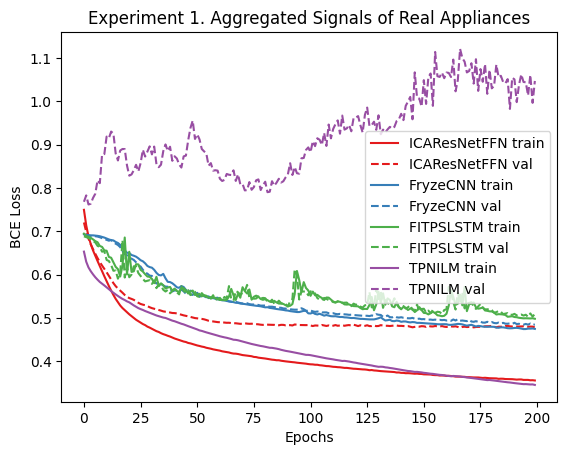

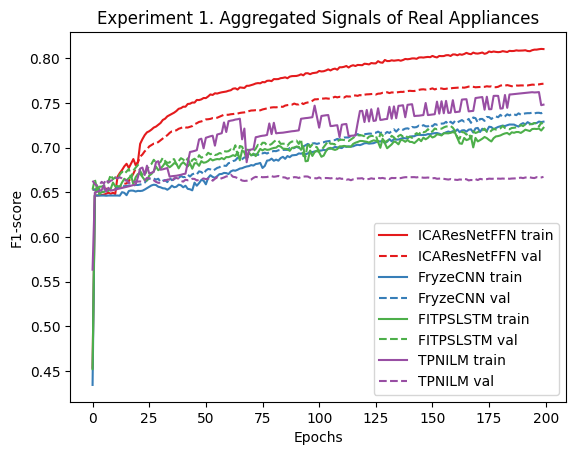

In [39]:
title = 'Experiment 1. Aggregated Signals of Real Appliances'

# Plot losses
plt.title(title)
for i, (model, _, hist) in enumerate(real):
    if hist is None:
        continue
    plt.plot(hist['train']['loss'],
             label='%s train' % model.__class__.__name__,
             color=colors[i])
    plt.plot(hist['val']['loss'],
             '--',
             label='%s val' % model.__class__.__name__,
             color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.savefig('./figures/real.loss.png', dpi=400)
plt.show()

# Plot F1-scores
plt.title(title)
for i, (model, _, hist) in enumerate(real):
    if hist is None:
        continue
    plt.plot(hist['train']['score'],
             label='%s train' % model.__class__.__name__,
             color=colors[i])
    plt.plot(hist['val']['score'],
             '--',
             label='%s val' % model.__class__.__name__,
             color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.savefig('./figures/real.f1.png', dpi=400)
plt.show()

Bar diagram

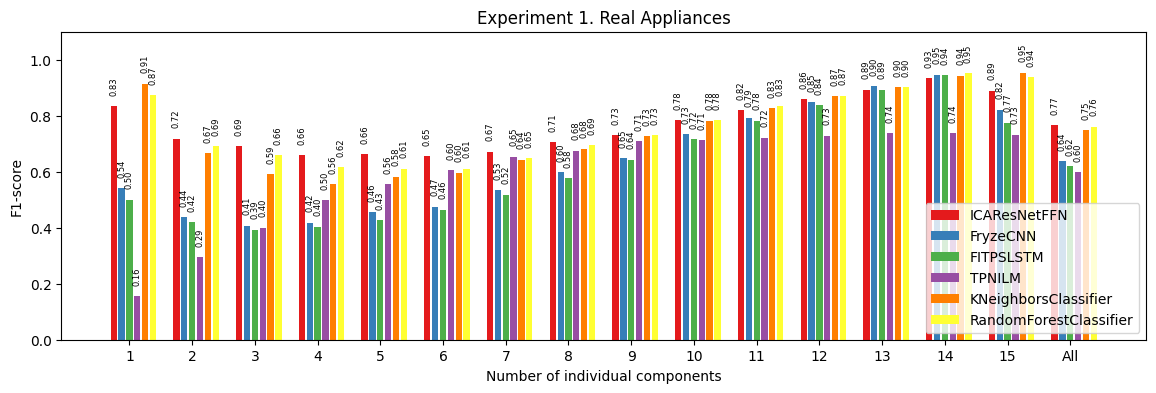

In [40]:
plt.figure(figsize=(14, 4))
plt.title('Experiment 1. Real Appliances')
plt.ylim([0, 1.1])

for i, (model, Y_pred, hist) in enumerate(real):

    rep = report(Y_pred, Y_real_test, components=range(n_min, n_max + 1))
    rep.to_csv('real.%s.csv' % model.__class__.__name__, sep='\t', index=True)
    rep = rep.astype(np.float32)

    w = 2
    xaxis = 20 * np.arange(1, rep.shape[1] + 1)
    bars = plt.bar(
        xaxis + 1.25 * w * np.arange(-len(real) // 2 + 1,
                                     len(real) // 2 + 1)[i],
        rep.loc['F1-score (samples)', :].values,
        width=w,
        color=colors[i],
        align='center',
        label=model.__class__.__name__,
    )
    plt.bar_label(bars, padding=8, fmt='%.2f', rotation=90, fontsize=6)

plt.xticks(xaxis, labels=rep.columns)
plt.xlabel('Number of individual components')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
os.makedirs('figures', exist_ok=True)
plt.savefig('./figures/real.f1.bars.png', dpi=400)
plt.show()

### Experiment 2. Mixtures of synthetic appliances

**NOTE**: You may skip all the cells in "Training and validation" till the section "Plots" by loading the results:

In [41]:
try:
    synth = np.load('data/synth.npy', allow_pickle=True)
except FileNotFoundError:
    pass

#### Training and validation

In [42]:
models = [ICAResNetFFN, FryzeCNN, FITPSLSTM, TPNILM]
params = [
    {
        'q': 64,  # d_model
        'p': 0.1,  # Dropout
        'U': U_synth,  # Un-mixing matrix
        'M': M_synth,
        'm': m_synth,
        's': s_synth,
        'parallel': False,
        'lr': 1e-3,
        'batch_size': len(X_synth_train),
    },
    {
        'parallel': False,
        'lr': 1e-3,
        'fryze': True,
        'batch_size': len(X_synth_train),
    },
    {
        'q': 50,  # Input dim for LSTM model
        'parallel': False,
        'lr': 1e-2,
        'batch_size': len(X_synth_train),
    },
    {
        'parallel': False,
        'lr': 1e-4,
        'batch_size': 256,
    },
]

synth = []
for model, kwargs in zip(models, params):
    parallel = kwargs.pop('parallel', False)
    lr = kwargs.pop('lr', 1e-2)
    batch_size = kwargs.pop('batch_size')
    fryze = kwargs.pop('fryze', False)
    model, hist = run_all(model(**kwargs),
                          X_synth_train,
                          X_synth_val,
                          Y_synth_train,
                          Y_synth_val,
                          epochs=200,
                          parallel=parallel,
                          batch_size=batch_size,
                          lr=lr,
                          fryze=fryze,
                          device='cuda',
                          prefix='synth')

    model.eval()
    with torch.no_grad():
        if fryze:
            X_test_prime = fryze_data(X_synth_test)
        else:
            X_test_prime = X_synth_test
        Y_pred = model(
            torch.tensor(X_test_prime, dtype=torch.float64, device='cuda'))
        Y_pred = Y_pred.cpu().numpy()
        Y_pred = np.where(Y_pred > hist['threshold'][-1], 1, 0)

    synth.append((model, Y_pred, hist))

Epoch 0/199
----------
Train Loss: 0.7075 f1: 0.5071
  Val Loss: 0.6611 f1: 0.6472
Epoch 1/199
----------
Train Loss: 0.6666 f1: 0.6471
  Val Loss: 0.6262 f1: 0.6536
Epoch 2/199
----------
Train Loss: 0.6324 f1: 0.6511
  Val Loss: 0.5962 f1: 0.6766
Epoch 3/199
----------
Train Loss: 0.6034 f1: 0.6705
  Val Loss: 0.5695 f1: 0.7022
Epoch 4/199
----------
Train Loss: 0.5772 f1: 0.6940
  Val Loss: 0.5454 f1: 0.7207
Epoch 5/199
----------
Train Loss: 0.5532 f1: 0.7135
  Val Loss: 0.5239 f1: 0.7372
Epoch 6/199
----------
Train Loss: 0.5323 f1: 0.7282
  Val Loss: 0.5052 f1: 0.7519
Epoch 7/199
----------
Train Loss: 0.5135 f1: 0.7425
  Val Loss: 0.4890 f1: 0.7620
Epoch 8/199
----------
Train Loss: 0.4973 f1: 0.7509
  Val Loss: 0.4747 f1: 0.7686
Epoch 9/199
----------
Train Loss: 0.4829 f1: 0.7581
  Val Loss: 0.4617 f1: 0.7775
Epoch 10/199
----------
Train Loss: 0.4701 f1: 0.7656
  Val Loss: 0.4499 f1: 0.7836
Epoch 11/199
----------
Train Loss: 0.4586 f1: 0.7740
  Val Loss: 0.4395 f1: 0.7901
Ep

In [43]:
# Save intermediate results
np.save('data/synth.npy', synth, allow_pickle=True)

In [44]:
X_synth_train = fica.fit_transform(X_synth_train)
X_synth_val = fica.transform(X_synth_val)
X_synth_test = fica.transform(X_synth_test)

scaler = StandardScaler()
X_synth_train = scaler.fit_transform(np.exp(X_synth_train))
X_synth_val = scaler.transform(np.exp(X_synth_val))
X_synth_test = scaler.transform(np.exp(X_synth_test))

In [45]:
cv = [(np.arange(len(X_synth_train)),
       np.arange(len(X_synth_train),
                 len(X_synth_train) + len(X_synth_val)))]
X_synth_train = np.concatenate((X_synth_train, X_synth_val))
Y_synth_train = np.concatenate((Y_synth_train, Y_synth_val))

In [46]:
for model, param_grid in param_grids.items():
    gsearch = GridSearchCV(model(),
                           param_grid,
                           cv=cv,
                           scoring=f1_score_samples,
                           verbose=99,
                           refit=True,
                           n_jobs=-1)
    gsearch.fit(X_synth_train, Y_synth_train)

    model_fit = gsearch.best_estimator_
    Y_pred = model_fit.predict(X_synth_test)
    synth.append((model_fit, Y_pred, None))

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV 1/1; 1/20] START leaf_size=10, n_neighbors=3................................
[CV 1/1; 1/20] END .leaf_size=10, n_neighbors=3;, score=0.856 total time=   0.8s
[CV 1/1; 17/20] START leaf_size=40, n_neighbors=5...............................
[CV 1/1; 16/20] START leaf_size=40, n_neighbors=3...............................
[CV 1/1; 2/20] START leaf_size=10, n_neighbors=5................................
[CV 1/1; 9/20] START leaf_size=20, n_neighbors=15...............................
[CV 1/1; 3/20] START leaf_size=10, n_neighbors=10...............................
[CV 1/1; 10/20] START leaf_size=20, n_neighbors=20..............................
[CV 1/1; 4/20] START leaf_size=10, n_neighbors=15...............................
[CV 1/1; 12/20] START leaf_size=30, n_neighbors=5...............................
[CV 1/1; 5/20] START leaf_size=10, n_neighbors=20...............................
[CV 1/1; 19/20] START leaf_size=40, n_neighbors=

In [47]:
# Save final results
np.save('data/synth.npy', synth, allow_pickle=True)

#### Plots

Loss function and F1-score

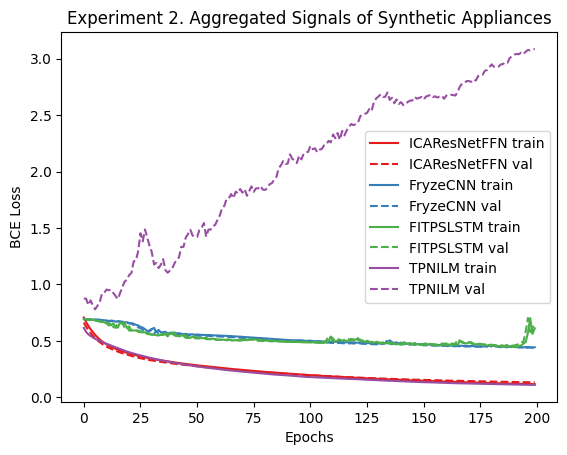

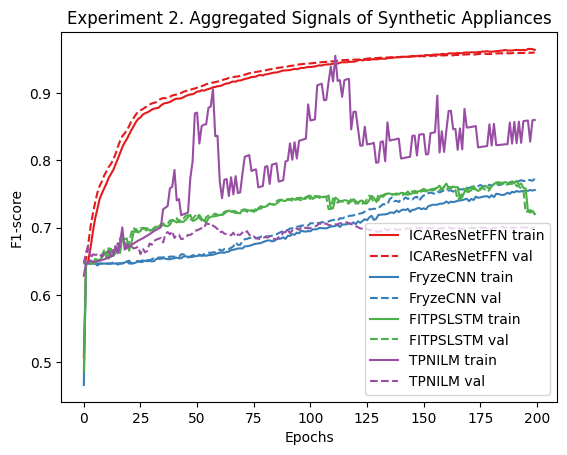

In [48]:
title = 'Experiment 2. Aggregated Signals of Synthetic Appliances'

# Plot losses 
plt.title(title)
for i, (model, _, hist) in enumerate(synth):
    if hist is None:
        continue
    plt.plot(hist['train']['loss'],
             label='%s train' % model.__class__.__name__,
             color=colors[i])
    plt.plot(hist['val']['loss'],
             '--',
             label='%s val' % model.__class__.__name__,
             color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.savefig('./figures/synth.loss.png', dpi=400)
plt.show()

# Plot F1-scores
plt.title(title)
for i, (model, _, hist) in enumerate(synth):
    if hist is None:
        continue
    plt.plot(hist['train']['score'],
             label='%s train' % model.__class__.__name__,
             color=colors[i])
    plt.plot(hist['val']['score'],
             '--',
             label='%s val' % model.__class__.__name__,
             color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.savefig('./figures/synth.f1.png', dpi=400)
plt.show()

Bar diagramm 

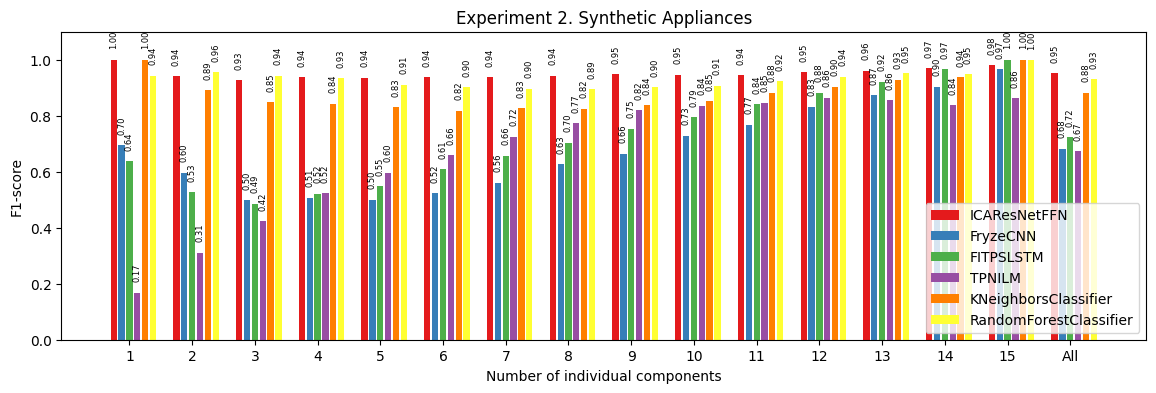

In [49]:
plt.figure(figsize=(14, 4))
plt.title('Experiment 2. Synthetic Appliances')
plt.ylim([0, 1.1])

for i, (model, Y_pred, hist) in enumerate(synth):

    rep = report(Y_pred, Y_synth_test, components=range(n_min, n_max + 1))
    rep.to_csv('synth.%s.csv' % model.__class__.__name__, sep='\t', index=True)
    rep = rep.astype(np.float32)

    w = 2
    xaxis = 20 * np.arange(1, rep.shape[1] + 1)
    bars = plt.bar(
        xaxis + 1.25 * w * np.arange(-len(synth) // 2 + 1,
                                     len(synth) // 2 + 1)[i],
        rep.loc['F1-score (samples)', :].values,
        width=w,
        color=colors[i],
        align='center',
        label=model.__class__.__name__,
    )
    plt.bar_label(bars, padding=8, fmt='%.2f', rotation=90, fontsize=6)

plt.xticks(xaxis, labels=rep.columns)
plt.xlabel('Number of individual components')
plt.ylabel('F1-score')
plt.legend(loc='lower right')
os.makedirs('figures', exist_ok=True)
plt.savefig('./figures/synth.f1.bars.png', dpi=400)
plt.show()

## Discussion

Obtain t-SNE embeddings of real and synthetic signatures (signals)

In [50]:
tsne = TSNE(2)
X_real_tsne = tsne.fit_transform(X_real)
X_synth_tsne = tsne.fit_transform(X_synth)

Visualize the embeddings

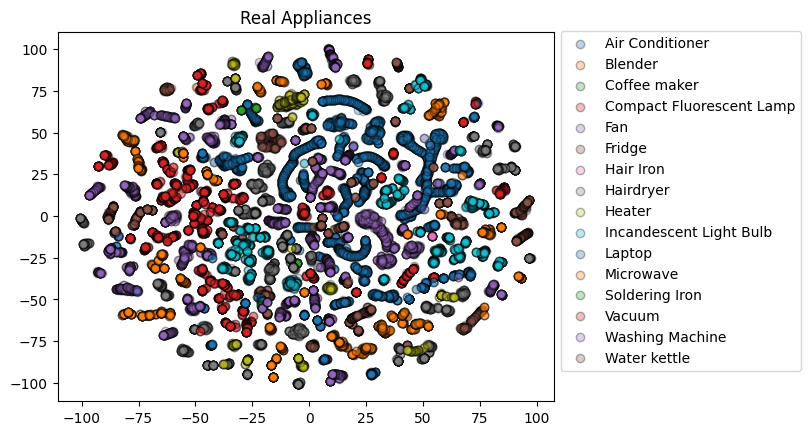

In [51]:
plt.title('Real Appliances')
y_real_dec = lenc.inverse_transform(y_real)
for k in lenc.classes_:
    mask = y_real_dec == k
    scatter = plt.scatter(*X_real_tsne[mask].T,
                          alpha=0.3,
                          cmap='tab20',
                          edgecolors='k')
plt.legend(lenc.classes_, bbox_to_anchor=(1.0, 1.02))
plt.savefig('./figures/real.tsne.png', dpi=400, bbox_inches='tight')
plt.show()

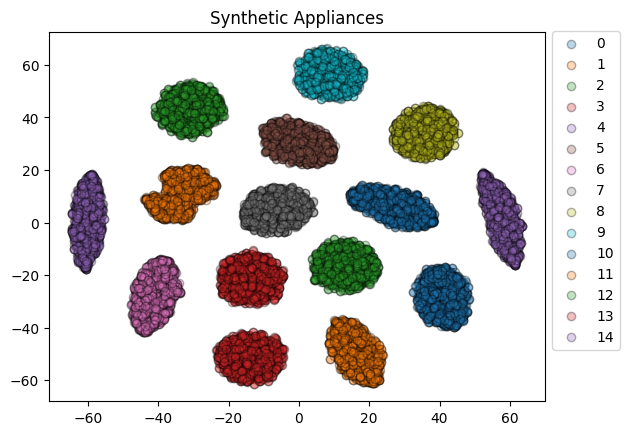

In [52]:
plt.title('Synthetic Appliances')
for k in np.unique(y_synth):
    mask = y_synth == k
    scatter = plt.scatter(*X_synth_tsne[mask].T,
                          alpha=0.3,
                          cmap='tab20',
                          edgecolors='k')
plt.legend(np.unique(y_synth), bbox_to_anchor=(1.0, 1.02))
plt.savefig('./figures/synth.tsne.png', dpi=400, bbox_inches='tight')
plt.show()